# Import Packages

In [2]:
import time
import warnings
from collections import deque
from scipy.optimize import linear_sum_assignment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
)

import umap
from skopt import BayesSearchCV
from skopt.space import Categorical
from skopt.callbacks import DeltaYStopper
from skopt.utils import point_asdict

from sentence_transformers import SentenceTransformer

warnings.filterwarnings("ignore", category=UserWarning)


# Load Data

In [3]:
df_min_cleaned = pd.read_csv("min_cleaned_tweets.csv")

df_min_cleaned_sample = pd.read_csv("min_cleaned_sample_tweets.csv")

# SBERT

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

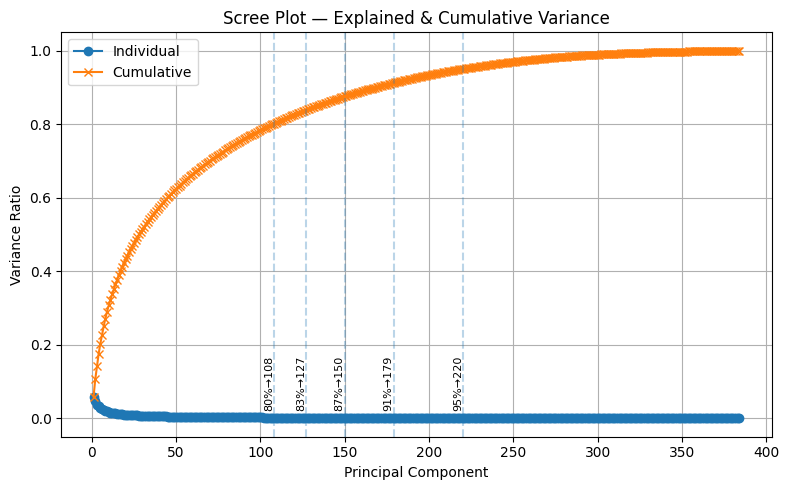

PCA n_components candidates (80–95% cum var): [108, 127, 150, 179, 220]

=== Running BayesSearchCV (SBERT + PCA/UMAP × KMeans/GMM/Agglo) ===


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Bayes] iter   4/60 ( 6.7%) | last 36.51s avg 36.51s | elapsed  0.6m ETA ~34.1m | branch pca+kmeans
[Bayes] iter   8/60 (13.3%) | last 24.46s avg 30.49s | elapsed  1.0m ETA ~26.4m | branch pca+kmeans
[Bayes] iter  12/60 (20.0%) | last  3.42s avg 21.47s | elapsed  1.1m ETA ~17.2m | branch pca+kmeans
[Bayes] iter  16/60 (26.7%) | last  4.31s avg 17.18s | elapsed  1.1m ETA ~12.6m | branch pca+kmeans
[Bayes] iter  20/60 (33.3%) | last  4.92s avg 14.72s | elapsed  1.2m ETA ~ 9.8m | branch pca+kmeans
[Bayes] iter  24/60 (40.0%) | last  6.46s avg 13.35s | elapsed  1.3m ETA ~ 8.0m | branch pca+kmeans
[Bayes] iter  28/60 (46.7%) | last  8.12s avg 12.60s | elapsed  1.5m ETA ~ 6.7m | branch pca+kmeans
[Bayes] iter  32/60 (53.3%) | last 11.19s avg 12.42s | elapsed  1.7m ETA ~ 5.8m | branch pca+kmeans
[Bayes] iter  36/60 (60.0%) | last  6.80s avg 11.80s | elapsed  1.8m ETA ~ 4.7m | branch pca+kmeans
[Bayes] iter  40/60 (66.7%) | last  8.30s avg 11.45s | elapsed  1.9m ETA ~ 3.8m | branch pca+kmeans


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Bayes] iter  60/60 (100.0%) | last 57.36s avg 24.11s | elapsed 24.1m ETA ~ 0.0m | branch umap+kmeans
[Bayes] iter   4/60 ( 6.7%) | last 65.22s avg 24.78s | elapsed 25.2m ETA ~23.1m | branch umap+gmm
[Bayes] iter   8/60 (13.3%) | last 40.91s avg 25.04s | elapsed 25.9m ETA ~21.7m | branch umap+gmm
[Bayes] iter  12/60 (20.0%) | last 44.85s avg 25.36s | elapsed 26.6m ETA ~20.3m | branch umap+gmm
[Bayes] iter  16/60 (26.7%) | last 66.15s avg 25.99s | elapsed 27.7m ETA ~19.1m | branch umap+gmm
[Bayes] iter  20/60 (33.3%) | last 65.15s avg 26.60s | elapsed 28.8m ETA ~17.7m | branch umap+gmm
[Bayes] iter  24/60 (40.0%) | last 66.50s avg 27.20s | elapsed 29.9m ETA ~16.3m | branch umap+gmm
[Bayes] iter  28/60 (46.7%) | last 89.73s avg 28.14s | elapsed 31.4m ETA ~15.0m | branch umap+gmm
[Bayes] iter  32/60 (53.3%) | last 69.07s avg 28.74s | elapsed 32.6m ETA ~13.4m | branch umap+gmm
[Bayes] iter  36/60 (60.0%) | last 67.32s avg 29.30s | elapsed 33.7m ETA ~11.7m | branch umap+gmm
[Bayes] iter  40

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Bayes] iter  60/60 (100.0%) | last 140.44s avg 34.65s | elapsed 43.3m ETA ~ 0.0m | branch umap+gmm


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Bayes] iter   4/60 ( 6.7%) | last 47.18s avg 34.81s | elapsed 44.1m ETA ~32.5m | branch umap+agglo
[Bayes] iter   8/60 (13.3%) | last 65.80s avg 35.22s | elapsed 45.2m ETA ~30.5m | branch umap+agglo
[Bayes] iter  12/60 (20.0%) | last 46.20s avg 35.36s | elapsed 46.0m ETA ~28.3m | branch umap+agglo
[Bayes] iter  16/60 (26.7%) | last 54.14s avg 35.59s | elapsed 46.9m ETA ~26.1m | branch umap+agglo
[Bayes] iter  20/60 (33.3%) | last 86.06s avg 36.23s | elapsed 48.3m ETA ~24.2m | branch umap+agglo
[Bayes] iter  24/60 (40.0%) | last 54.55s avg 36.45s | elapsed 49.2m ETA ~21.9m | branch umap+agglo
[Bayes] iter  28/60 (46.7%) | last 57.62s avg 36.71s | elapsed 50.2m ETA ~19.6m | branch umap+agglo
[Bayes] iter  32/60 (53.3%) | last 74.77s avg 37.17s | elapsed 51.4m ETA ~17.3m | branch umap+agglo
[Bayes] iter  36/60 (60.0%) | last 84.53s avg 37.73s | elapsed 52.8m ETA ~15.1m | branch umap+agglo
[Bayes] iter  40/60 (66.7%) | last 91.45s avg 38.36s | elapsed 54.3m ETA ~12.8m | branch umap+agglo


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Bayes] iter  60/60 (100.0%) | last 60.36s avg 41.01s | elapsed 61.5m ETA ~ 0.0m | branch umap+agglo


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,estimator,ClusteringPipeline()
,search_spaces,"[{'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, {'cov_type': Categorical(c...), prior=None), 'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, ...]"
,optimizer_kwargs,None
,n_iter,60
,scoring,None
,fit_params,None
,n_jobs,-1
,n_points,4
,iid,'deprecated'
,refit,True
,cv,"[(array([ 0, ...shape=(2928,)), ...)]"


In [4]:
# ---------------------------
# CONFIG
# ---------------------------
RANDOM_STATE = 42
SBERT_MODEL  = "all-MiniLM-L6-v2"  

# ---------------------------
# SBERT Embeddings
# ---------------------------
texts_sample = df_min_cleaned_sample["text"].astype(str).tolist()
texts_full   = df_min_cleaned["text"].astype(str).tolist()

le = LabelEncoder()

all_labels = pd.concat([
    df_min_cleaned["airline_sentiment"].astype(str),
    df_min_cleaned_sample["airline_sentiment"].astype(str)
], axis=0)
le.fit(all_labels)

# Transform in the same row order as texts_sample/texts_full 
y_full   = le.transform(df_min_cleaned["airline_sentiment"].astype(str))
y_sample = le.transform(df_min_cleaned_sample["airline_sentiment"].astype(str))

sbert = SentenceTransformer(SBERT_MODEL)
EMB_DIM = sbert.get_sentence_embedding_dimension()

X_sbert_sample = sbert.encode(
    texts_sample, batch_size=256, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=False
)
X_sbert_full = sbert.encode(
    texts_full, batch_size=256, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=False
)

# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    if max_components is None:
        max_components = min(EMB_DIM, X.shape[1])
    Xs   = StandardScaler().fit_transform(X)
    pca  = PCA(n_components=max_components, random_state=RANDOM_STATE)
    pca.fit(Xs)
    evr  = pca.explained_variance_ratio_
    cum  = np.cumsum(evr)

    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # dedupe
    seen, comps_unique = set(), []
    for c in comps:
        if c not in seen:
            comps_unique.append(c); seen.add(c)

    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        cand = min(max_components, comps_unique[-1] + step)
        if cand not in seen:
            comps_unique.append(cand); seen.add(cand)
        else:
            cand = min(max_components, cand+1)
            if cand not in seen:
                comps_unique.append(cand); seen.add(cand)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    if plot:
        xs = np.arange(1, len(evr)+1)
        plt.figure(figsize=(8,5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t*100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component'); plt.ylabel('Variance Ratio')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return comps_unique, cum

pca_candidates, _cum = pick_pca_candidates(
    X_sbert_sample, pct_low=0.80, pct_high=0.95, k=5, max_components=EMB_DIM, plot=True
)
print("PCA n_components candidates (80–95% cum var):", pca_candidates)

# UMAP candidate grids 
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline (tuning version with fast UMAP)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer': self.reducer, 'n_components': self.n_components,
            'n_neighbors': self.n_neighbors, 'min_dist': self.min_dist,
            'n_components_umap': self.n_components_umap, 'model': self.model,
            'cov_type': self.cov_type, 'linkage': self.linkage
        })

        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,       # speed tweak for tuning only
                low_memory=True
            ).fit_transform(X_l2)

        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan',
                            random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

# ---------------------------
# Conditional search space 
# ---------------------------
search_spaces = [
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback ---
TOTAL_ITERS = 60
_timings, _start, _prev = [], [None], [None]

def _infer_branch_from_space(space):
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if cats and hasattr(cats, "__iter__") and len(cats) == 1:
            v = cats[0]
            if v in ("pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    now = time.perf_counter()
    if _start[0] is None: _start[0] = now
    if _prev[0] is not None: _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try params → else infer branch from subspace
    branch = None
    try:
        if res.x_iters:
            lp = point_asdict(res.space, res.x_iters[-1])
            r, m = lp.get("reducer"), lp.get("model")
            if r and m: branch = f"{r}+{m}"
    except Exception:
        pass
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch}",
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run BayesSearchCV on SBERT sample
# ---------------------------
n = X_sbert_sample.shape[0]
dummy_y = np.zeros(n, dtype=int)  # placeholder to satisfy BayesSearchCV.fit
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,          # uses estimator.score() (silhouette)
    cv=cv_full,
    n_points=4,
    n_jobs=-1,
    return_train_score=False
)

print("\n=== Running BayesSearchCV (SBERT + PCA/UMAP × KMeans/GMM/Agglo) ===")
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

callbacks = [DeltaYStopper(delta=1e-4, n_best=15), progress_callback]
search.fit(X_sbert_sample, dummy_y, callback=callbacks)

In [5]:
# Final pipeline (remove UMAP speed tweaks)
class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE
            ).fit_transform(X_l2)

        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan',
                            random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

def _params_compact(d):
    order = ["reducer","model","n_components",
             "n_neighbors","min_dist","n_components_umap",
             "cov_type","linkage"]
    return ", ".join(f"{k}={d[k]}" for k in order if k in d and pd.notnull(d[k]))

# Best per branch on subset
cv = pd.DataFrame(search.cv_results_)
param_cols = [c for c in cv.columns if c.startswith("param_")]
score_col  = "mean_test_score"

for c in param_cols:
    cv[c] = cv[c].apply(lambda x: x if isinstance(x, (str,int,float,type(None))) else str(x))

cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer','?')}+{r.get('param_model','?')}", axis=1)
best_idx = cv.groupby("branch")[score_col].idxmax()
best_rows = cv.loc[best_idx].reset_index(drop=True)

subset_records = []
for _, r in best_rows.iterrows():
    params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
    subset_records.append({
        "branch": r["branch"],
        "best_sil_subset": round(float(r[score_col]), 4),
        **params
    })

df_best_subset = pd.DataFrame(subset_records).sort_values("branch")

print("\n================ Best Parameters per Branch (SBERT, 20% subset) ================\n")
print(df_best_subset[[
    "branch","best_sil_subset","reducer","model","n_components",
    "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))

# Refit each best branch on FULL SBERT embeddings
final_rows = []
for _, row in df_best_subset.iterrows():
    params = {}
    for k in ["reducer","model","n_components","n_neighbors","min_dist",
              "n_components_umap","cov_type","linkage"]:
        if k in row and pd.notnull(row[k]):
            val = row[k]
            if k in ["n_components","n_neighbors","n_components_umap"] and not pd.isna(val):
                val = int(val)
            if k == "min_dist" and not pd.isna(val):
                val = float(val)
            params[k] = val

    mdl = ClusteringPipeline(**params)
    mdl.fit(X_sbert_full)
    labels = mdl.labels_
    metric = getattr(mdl, "metric", "cosine")
    sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full, labels, metric)

    final_rows.append({
        "branch": row["branch"],
        "Silhouette": round(sil, 3),
        "ARI": round(ari, 3),
        "NMI": round(nmi, 3),
        "Hungarian": round(acc, 3),
        "Params": _params_compact(params)
    })

df_final = pd.DataFrame(final_rows).sort_values("branch")

print("\n================ Final Evaluation on Full Minimal-Cleaned Data (SBERT — Best of Each Branch) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))

for metric in ["Silhouette","ARI","NMI","Hungarian"]:
    r = df_final.loc[df_final[metric].idxmax()]
    print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")



================ Best Parameters per Branch (SBERT, 20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap cov_type  linkage
  pca+agglo           0.0518     pca  agglo         150.0          NaN       NaN                NaN      NaN complete
    pca+gmm           0.0479     pca    gmm         108.0          NaN       NaN                NaN     full      NaN
 pca+kmeans           0.0920     pca kmeans         108.0          NaN       NaN                NaN      NaN      NaN
 umap+agglo           0.5006    umap  agglo           NaN         45.0       0.1               16.0      NaN complete
   umap+gmm           0.3319    umap    gmm           NaN         60.0       0.1               96.0     tied      NaN
umap+kmeans           0.5029    umap kmeans           NaN        100.0       0.1               16.0      NaN      NaN

================ Final Evaluation on Full Minimal-Cleaned Data (SBERT — Best of Each Branc